In [1]:
from dpks.quant_matrix import QuantMatrix
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration, HDBSCAN

import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
design_matrix = pd.read_csv(
    #"../tests/input_files/design_sepsis.tsv",
    "/home/aaron/projects/dpks/notebooks/ml_api/covid_design_matrix.tsv",
    sep="\t"
)

In [3]:
design_matrix = design_matrix.sort_values("group", ascending=False).reset_index(drop=True)
design_matrix

,sample,WHO grade,group
0,20200520_TOF1_AF_002_ZeBanC_P1_A1,7,2
1,20200520_TOF1_AF_545_ZeBanC_P4_H9,6,2
2,20200520_TOF1_AF_567_ZeBanC_P6_B9,6,2
3,20200710_TOF1_LS_239_ZeBanc2_P1_C12,7,2
4,20200710_TOF1_LS_240_ZeBanc2_P3_H1,7,2
...,...,...,...
682,20200520_TOF1_AF_468_ZeBanC_P4_C6,4,1
683,20200520_TOF1_AF_460_ZeBanC_P4_B12,4,1
684,20200520_TOF1_AF_454_ZeBanC_P4_B7,3,1
685,20200520_TOF1_AF_452_ZeBanC_P4_B6,3,1


In [4]:
design_matrix['group'].value_counts()

group
2    406
1    281
Name: count, dtype: int64

In [5]:
qm = QuantMatrix(
    quantification_file="/home/aaron/projects/dpks/notebooks/ml_api/quantified_proteins.tsv", #../tests/input_files/data_sepsis.tsv",
    design_matrix_file=design_matrix
).impute(method="neighborhood")

In [6]:
qm = qm.compare(
    method="linregress",
    min_samples_per_group=10,
    comparisons=[(2, 1)]
)

In [7]:
X, y = qm.to_ml()

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X[:] = scaler.fit_transform(X[:])

In [11]:
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Lasso, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost

# clf = xgboost.XGBClassifier(
#     max_depth=2,
#     #subsample=0.5,
#     reg_lambda=2,
#     # objective="binary:logitraw",
#     # seed=42,
#     # eval_metric="logloss",
# )
#clf = HistGradientBoostingClassifier()
clf = LogisticRegression()
#clf = SVC(kernel="linear")
#clf = RandomForestClassifier()
#clf = Lasso()
#clf = AdaBoostClassifier()
#clf = SGDClassifier()

clf.fit(X, y.values.ravel())

LogisticRegression()

In [12]:
from sklearn.inspection import permutation_importance


importances = permutation_importance(
    clf,
    X,
    y,
    scoring="neg_log_loss",
    n_jobs=1,
    #max_samples=0.5,
    n_repeats=1,
)

In [13]:
feature_importances = pd.DataFrame(
    {
        "feature": X.columns,
        "importance": importances['importances_mean']
    }
)

In [14]:
feature_importances.sort_values("importance", ascending=False)

,feature,importance
62,P06312,0.082670
22,P01023,0.072246
17,P06396,0.065779
74,P04004,0.059882
0,P00747,0.053679
...,...,...
121,P29622,-0.000112
73,P01834,-0.000134
71,P01602,-0.000263
146,A0A0J9YX35,-0.000355


<Axes: xlabel='importance', ylabel='feature'>

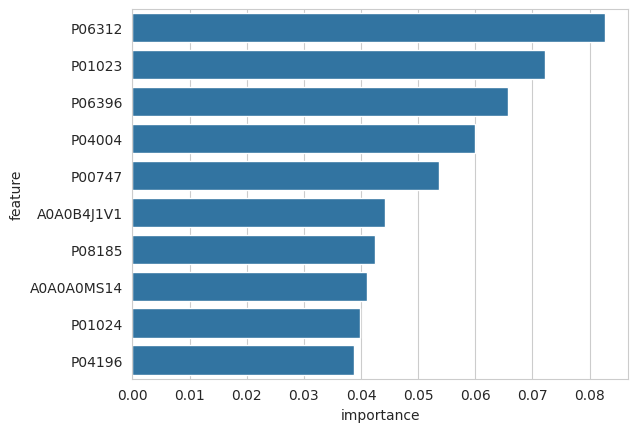

In [15]:
sns.barplot(x="importance", y="feature", data=feature_importances.sort_values("importance", ascending=False).head(10))

In [16]:
from dpks.inspection import FeatureImportance

importance_calculator = FeatureImportance(
    n_iterations=3,
    feature_names=X.columns.values,
)

importance_calculator.fit(clf, X)

In [17]:
feature_importances['loss_importance'] = importance_calculator.global_explanations

In [18]:
feature_importances.sort_values("loss_importance", ascending=False)

,feature,importance,loss_importance
62,P06312,0.082670,1.377032
22,P01023,0.072246,1.188384
17,P06396,0.065779,1.114364
0,P00747,0.053679,1.086481
74,P04004,0.059882,1.062740
...,...,...,...
93,P07998,-0.000014,0.009001
70,A0A0B4J1X5,-0.000002,0.008203
40,P02765,-0.000034,0.008152
151,Q15166,-0.000018,0.006842


<Axes: xlabel='loss_importance', ylabel='feature'>

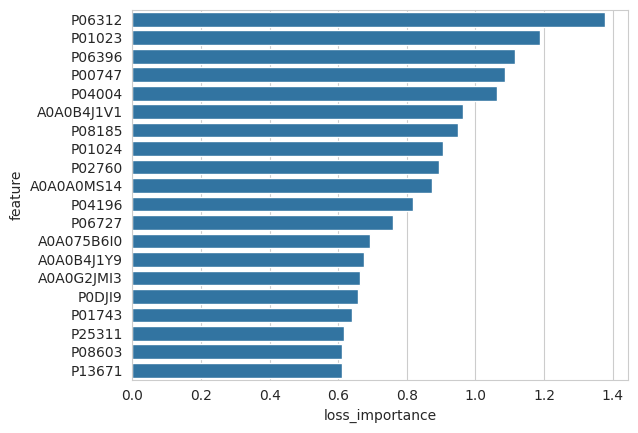

In [19]:
sns.barplot(
    data=feature_importances.sort_values("loss_importance", ascending=False).head(20),
    x="loss_importance",
    y="feature"
)

In [20]:
import shap

In [21]:
explainer = shap.LinearExplainer(clf, X)
#explainer = shap.TreeExplainer(clf)
shap_values = explainer(X)

In [22]:
feature_importances['shap_importance'] = np.mean(abs(shap_values.values), axis=0)

In [23]:
feature_importances.sort_values("shap_importance", ascending=False)

,feature,importance,loss_importance,shap_importance
62,P06312,0.082670,1.377032,1.241280
22,P01023,0.072246,1.188384,1.087185
0,P00747,0.053679,1.086481,1.034678
17,P06396,0.065779,1.114364,1.028571
74,P04004,0.059882,1.062740,0.983177
...,...,...,...,...
93,P07998,-0.000014,0.009001,0.008447
70,A0A0B4J1X5,-0.000002,0.008203,0.007482
40,P02765,-0.000034,0.008152,0.007452
151,Q15166,-0.000018,0.006842,0.006181


<Axes: xlabel='shap_importance', ylabel='feature'>

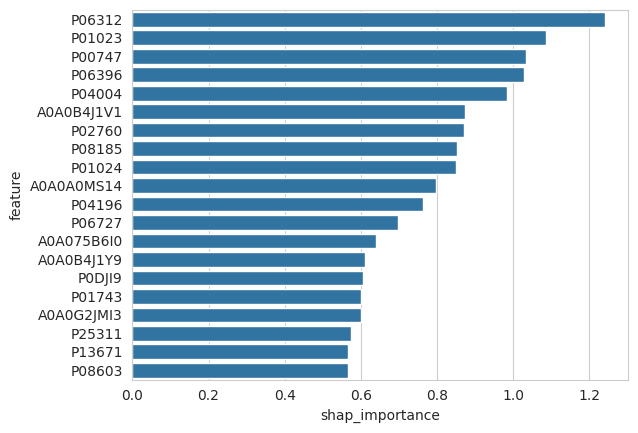

In [24]:
sns.barplot(
    data=feature_importances.sort_values("shap_importance", ascending=False).head(20),
    x="shap_importance",
    y="feature"
)

<Axes: xlabel='shap_importance', ylabel='loss_importance'>

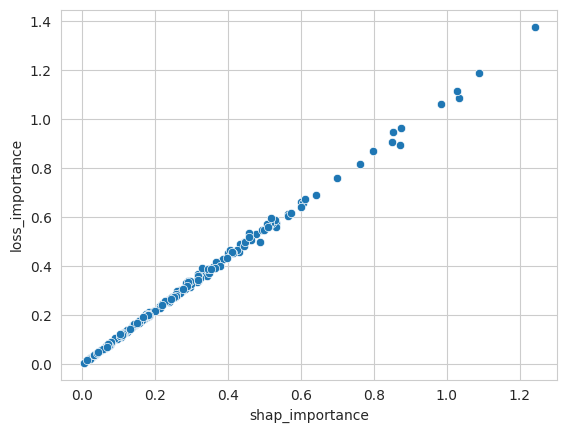

In [25]:
sns.scatterplot(
    data=feature_importances,
    x="shap_importance",
    y="loss_importance",
)

<Axes: xlabel='importance', ylabel='loss_importance'>

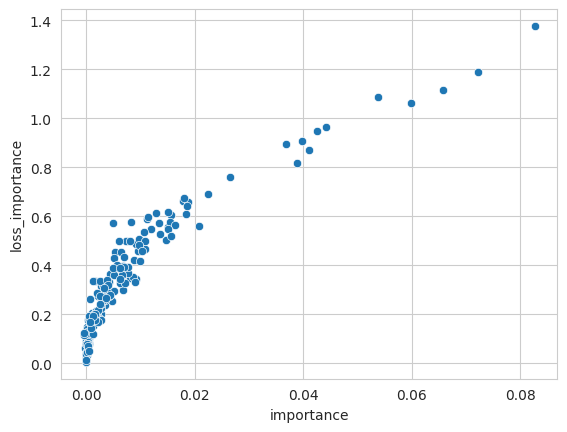

In [26]:
sns.scatterplot(
    data=feature_importances,
    x="importance",
    y="loss_importance",
)

<Axes: xlabel='importance', ylabel='shap_importance'>

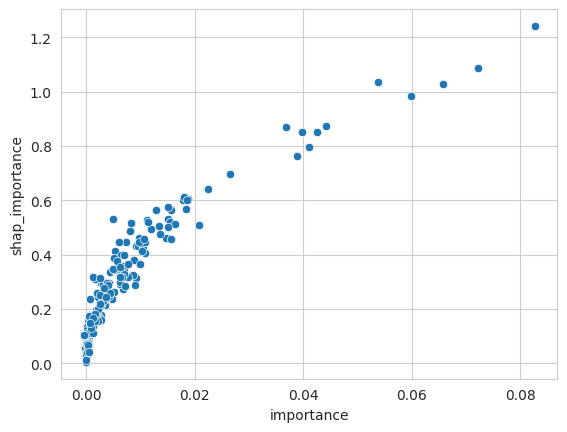

In [27]:
sns.scatterplot(
    data=feature_importances,
    x="importance",
    y="shap_importance",
)

In [28]:
explanations = pd.DataFrame(
    importance_calculator.local_explanations.T,
    columns=list(X.columns.values),
    index=list(X.index.values)
)

In [29]:
explanations = explanations.join(y)

In [30]:
explanations_melted = explanations.reset_index(names="Sample").melt(
    id_vars=["Sample", "label"]
)

In [31]:
feature_importances.sort_values("loss_importance", ascending=False)

,feature,importance,loss_importance,shap_importance
62,P06312,0.082670,1.377032,1.241280
22,P01023,0.072246,1.188384,1.087185
17,P06396,0.065779,1.114364,1.028571
0,P00747,0.053679,1.086481,1.034678
74,P04004,0.059882,1.062740,0.983177
...,...,...,...,...
93,P07998,-0.000014,0.009001,0.008447
70,A0A0B4J1X5,-0.000002,0.008203,0.007482
40,P02765,-0.000034,0.008152,0.007452
151,Q15166,-0.000018,0.006842,0.006181


In [32]:
explanations_melted

,Sample,label,variable,value
0,20200520_TOF1_AF_002_ZeBanC_P1_A1,1,P00747,-0.360183
1,20200520_TOF1_AF_545_ZeBanC_P4_H9,1,P00747,-1.848275
2,20200520_TOF1_AF_567_ZeBanC_P6_B9,1,P00747,1.396754
3,20200710_TOF1_LS_239_ZeBanc2_P1_C12,1,P00747,1.628322
4,20200710_TOF1_LS_240_ZeBanc2_P3_H1,1,P00747,-3.084835
...,...,...,...,...
129838,20200520_TOF1_AF_468_ZeBanC_P4_C6,0,P02745,0.143144
129839,20200520_TOF1_AF_460_ZeBanC_P4_B12,0,P02745,-0.134044
129840,20200520_TOF1_AF_454_ZeBanC_P4_B7,0,P02745,0.522814
129841,20200520_TOF1_AF_452_ZeBanC_P4_B6,0,P02745,-0.185551


In [33]:
explanations_melted['mean'] = explanations_melted.groupby("variable")['value'].transform(lambda x: np.mean(np.abs(x)))

In [34]:
explanations_melted = explanations_melted.sort_values("mean", ascending=False)

In [35]:
explanations_melted = explanations_melted[explanations_melted['variable'].isin(explanations_melted['variable'].unique()[:10])]

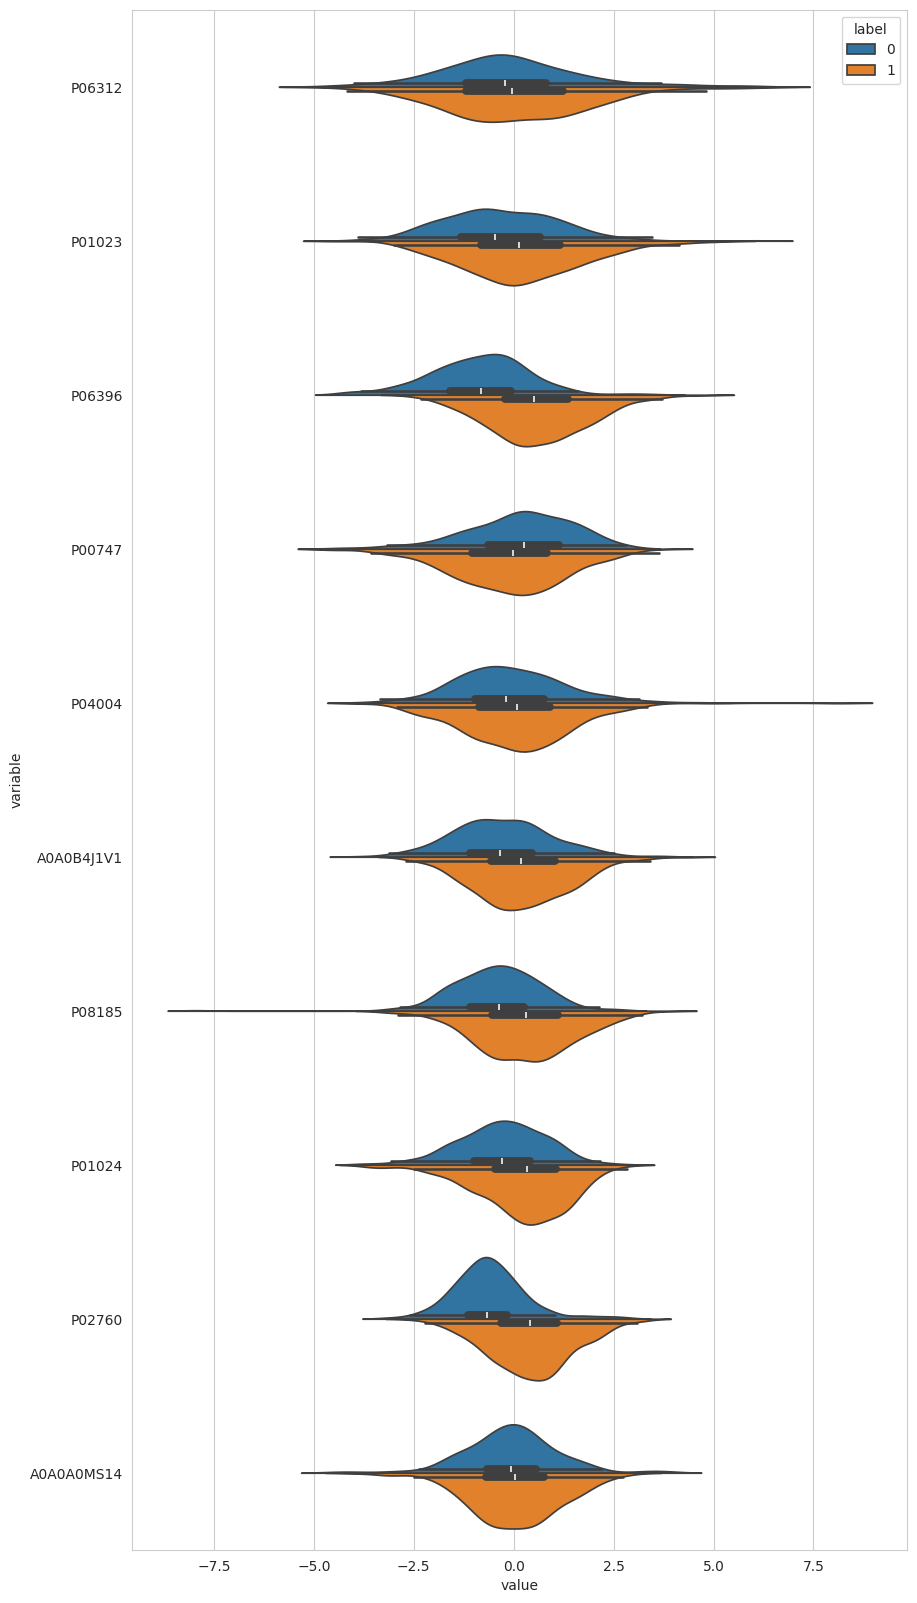

In [36]:
sns.set_style("whitegrid")

ax = sns.violinplot(
    data=explanations_melted,
    x="value",
    y="variable",
    hue="label",
    split=True
)

ax.figure.set_size_inches((10, 20))

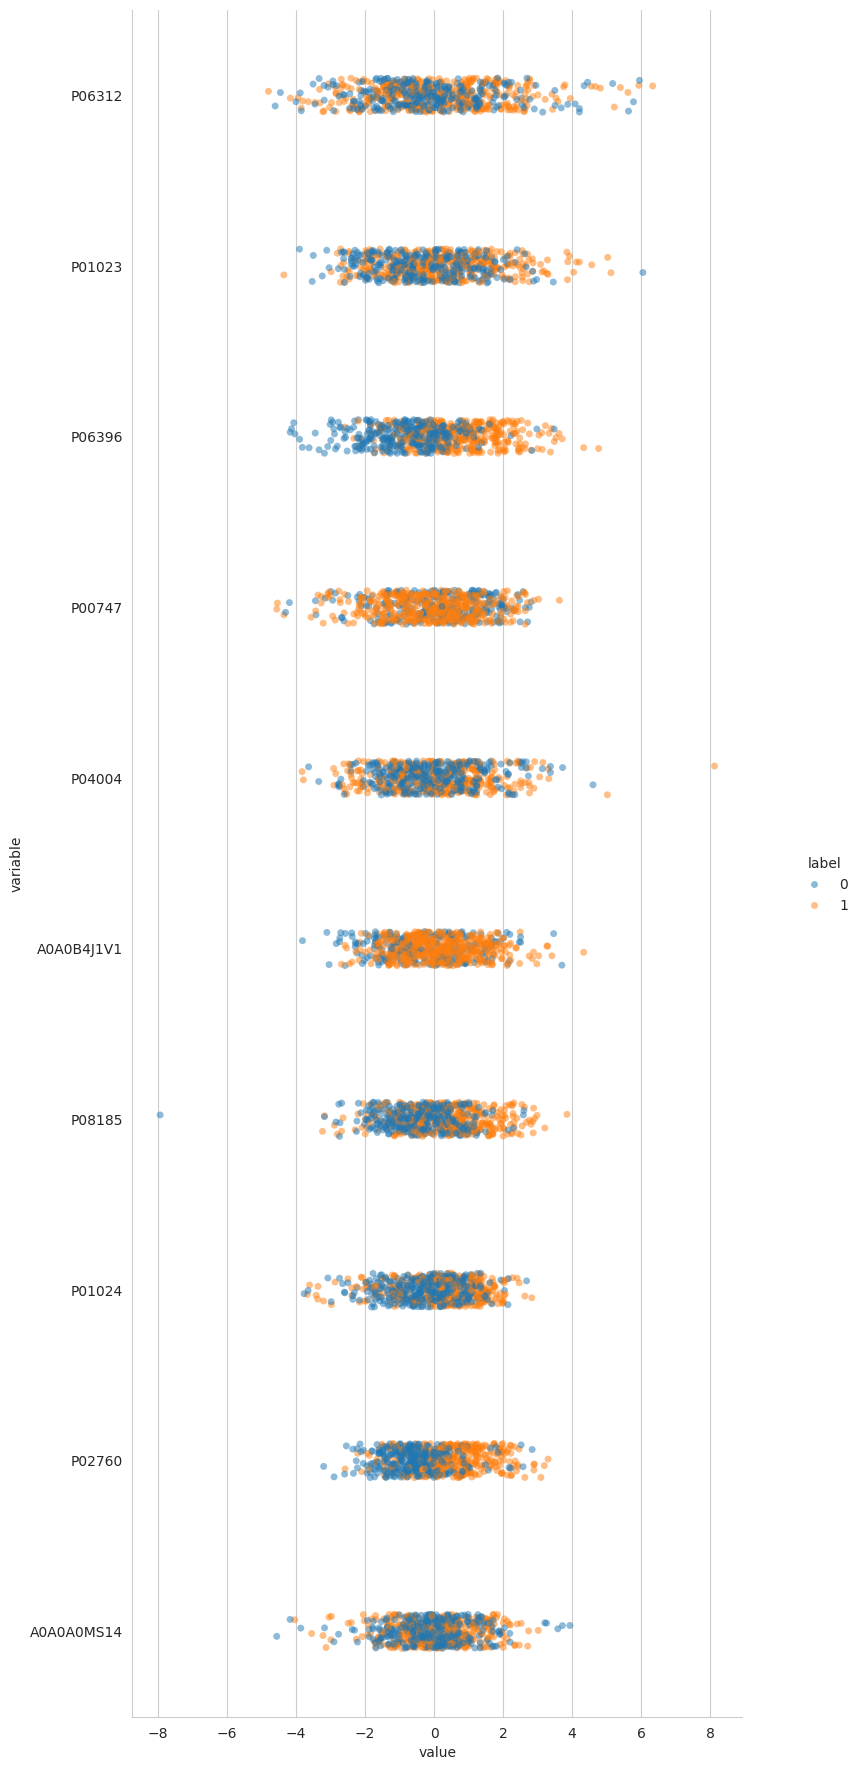

In [49]:
import matplotlib.pyplot as plt


# Show each observation with a scatterplot
ax = sns.catplot(data=explanations_melted, x="value", y="variable", hue="label", alpha=0.5)

ax.figure.set_size_inches((10, 20))


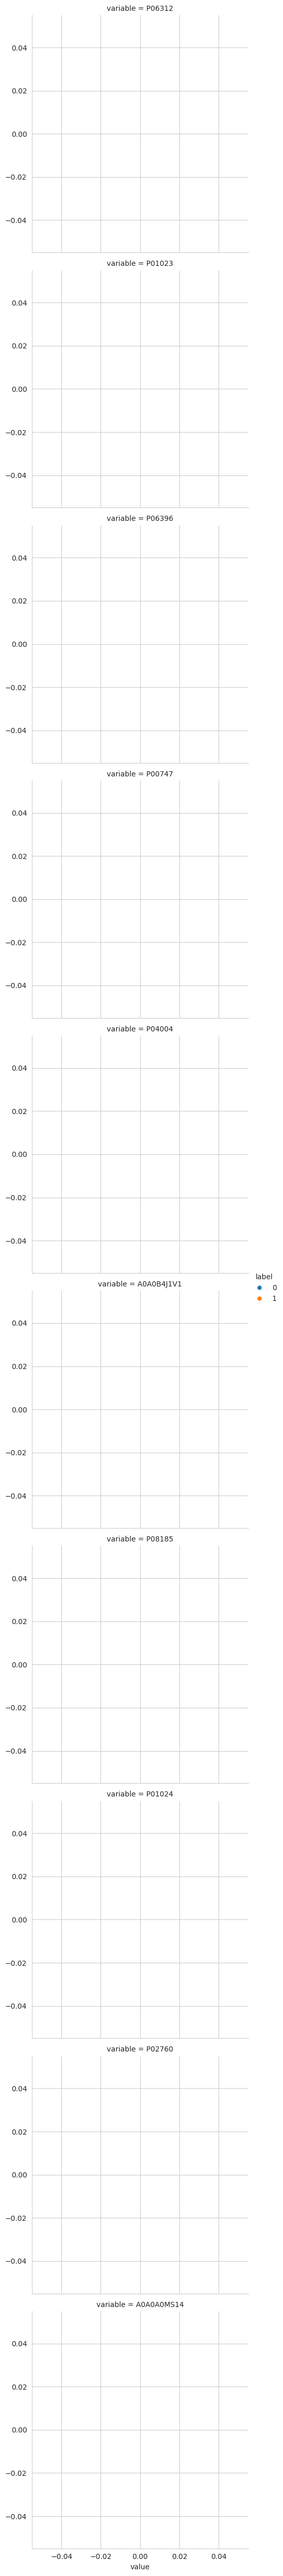

In [45]:
sns.relplot(
    explanations_melted,
    x="value",
    hue="label",
    row="variable"
)
